# Matrix Factorization 1

* 최근 추천 시스템의 근간인 Matrix Factoization 모델에 대해서 알아 봅니다.

In [66]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
# MovieLens 100K를 데이터셋을 불러옵니다.
df_ratings = pd.read_csv('dataset/ratings_100k.csv')
df_ratings['date'] = df_ratings.pop('timestamp').pipe(lambda x: pd.to_datetime(x, unit='s'))
df_user = pd.read_csv('dataset/users_100k.csv', index_col='user id')
df_movie = pd.read_csv('dataset/movies_100k.csv', index_col='movie id')

## 상호작용(Iteraction)

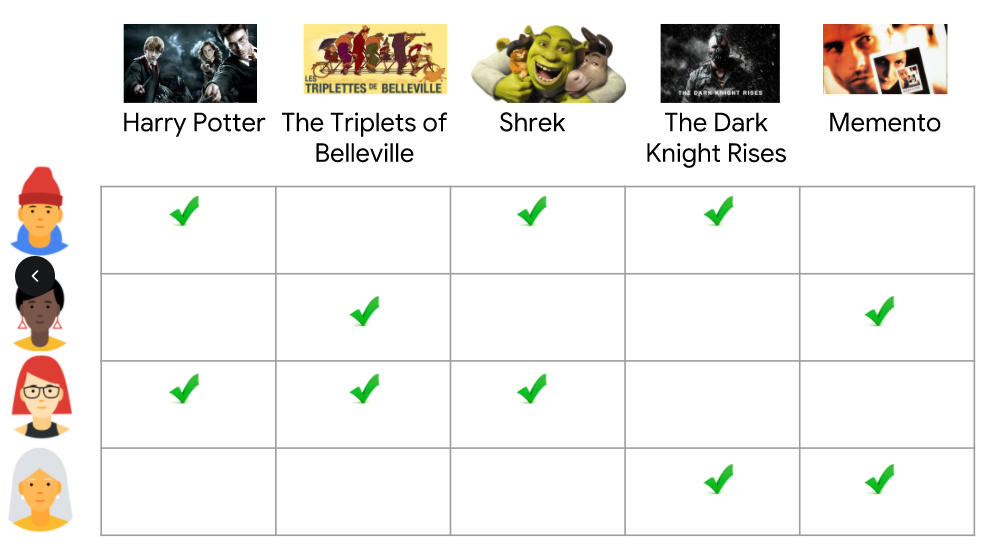

두 가지 이상의 요소에 의해 대상의 양상이 달라지는 현상.

**개인취향**


**Iteraction Matrix**

예제) MovieLen 100K 데이터셋에서 Interaction Matrix를 만들어봅니다.

평졈 호불호가 분명한 영화 몇 개와 사용자 몇 명을 뽑아 상호 작용 행렬의 예를 들어 봅니다.

In [136]:
# 1990년대 유명하고 제목이 짧은 영화 몇 편 뽑습니다.
item_index = [1, 226, 96, 402, 69, 29]
df_movie.loc[df_movie.index.isin(item_index)]

,movie title,release date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie id,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
29,Batman Forever (1995),01-Jan-1995,0,1,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
69,Forrest Gump (1994),01-Jan-1994,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
96,Terminator 2: Judgment Day (1991),01-Jan-1991,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
226,Die Hard 2 (1990),01-Jan-1990,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
402,Ghost (1990),01-Jan-1990,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,1,0,0


In [137]:
# 평점의 표준편차가 1이 넘고 선정한 영화를 3건 넘게 시청한 사용자 중 평점순으로 10명을 뽑습니다.
df_user.loc[
    df_ratings.groupby('user id').filter(
        lambda x: x['rating'].std() > 1 and x['item id'].isin(item_index).sum() > 3
    )['user id'].value_counts().head(10).index
]

,age,gender,occupation,zip code
user id,,,,
405,22,F,healthcare,10019
13,47,M,educator,29206
276,21,M,student,95064
416,20,F,student,92626
303,19,M,student,14853
279,33,M,programmer,85251
846,27,M,lawyer,47130
7,57,M,administrator,91344
94,26,M,student,71457


In [138]:
# 위에서 선정한 영화를 적어도 3편 넘게 본 10명의 사용자를 뽑습니다.
user_index = df_ratings.groupby('user id').filter(
    lambda x: x['rating'].std() > 1 and x['item id'].isin(item_index).sum() > 3
)['user id'].value_counts().head(10).index

# 피벗을 통해 사용자 × 영화로 구성된 상호작용행렬을 만듭니다.
df_interaction = df_ratings.loc[
    df_ratings['item id'].isin(item_index) &
    df_ratings['user id'].isin(user_index)
].join(df_movie['movie title'], on='item id')\
.join(df_user[['age', 'gender', 'occupation']].astype('str').apply(lambda x: '/'.join(x), axis=1).rename('user'), on='user id')\
.pivot(index='user',  columns='movie title', values='rating').sort_index().sort_index(axis=1)
df_interaction

movie title,Batman Forever (1995),Die Hard 2 (1990),Forrest Gump (1994),Ghost (1990),Terminator 2: Judgment Day (1991),Toy Story (1995)
user,,,,,,
19/M/student,2.0,4.0,5.0,4.0,5.0,5.0
20/F/student,2.0,4.0,4.0,5.0,4.0,5.0
21/M/student,3.0,4.0,4.0,3.0,5.0,5.0
22/F/healthcare,4.0,2.0,4.0,3.0,3.0,NaN
23/M/programmer,2.0,3.0,4.0,NaN,4.0,4.0
26/M/student,2.0,2.0,3.0,4.0,3.0,4.0
27/M/lawyer,2.0,4.0,5.0,NaN,4.0,NaN
33/M/programmer,2.0,4.0,NaN,NaN,4.0,3.0
47/M/educator,2.0,4.0,4.0,4.0,4.0,3.0


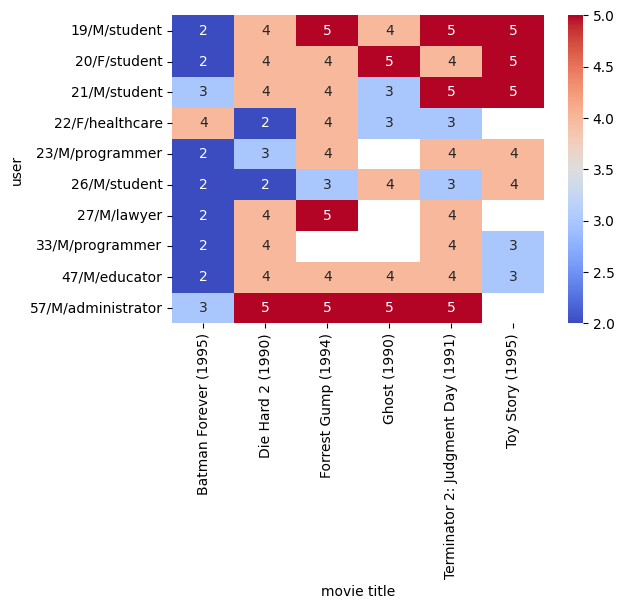

In [139]:
plt.figure(figsize=(6, 4))
cmap_coolwarm = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(df_interaction, cmap=cmap_coolwarm, annot=True)
plt.show()

# Matrix Factorization

상호작용을 모델링하기 위한 모델

> Sparsity가 큰 Sparse Matrix입니다.

> 크기는 User와 Item의 수의 곱입니다. 

$N_{user}×N_{item}$의 상호작용 행렬(Matrix)을 

$N_{user}×Rank$사용자 행렬과 $N_{item}×Rank$아이템 행렬 두 개의 행렬곱으로 분해하는 모델입니다.

$Interaction = User × Item^T$


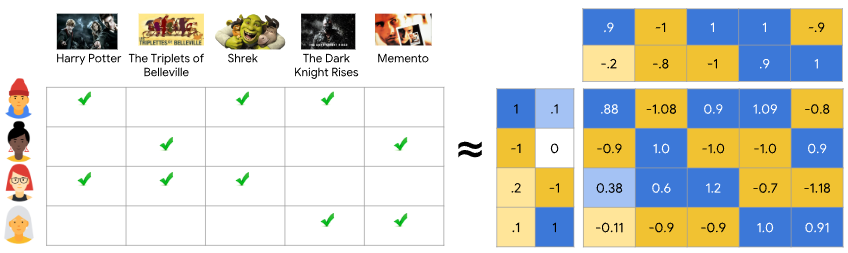


사용자 행렬: $N_{user}×Rank$ - 사용자 임베딩

아이템 행렬: $N_{item}×Rank$ - 아이템 임베딩


## 학습 알고리즘

### ALS(Alternating Least Square):

Loss: Mean Squared Error 



아이템(영화)의 임베딩을 item id에 맵핑하여 입력변수로 하고 사용자별 평점을 대상 변수로 하여 선형 회귀 모델을 학습합니다. 

사용자 별로 선형 회귀 계수를 사용자 임베딩으로 업데이트를 합니다.

반대로, 사용자의 임베딩을 user id에 맵핑하여 입력변수로 하고 아이템별 평점을 대상 변수로 하여 선형 회귀 모델을 학습합니다.

아이템 별로 선형 회귀 계수를 아이템 임베딩으로 업데이트를 합니다.

사용자 임베딩과 아이템 임베딩을 사용자 / 아이템 번갈아 가면서 

학습시킵니다.

(1) 사용자 / 아이템 임베딩 초기화

(2-1) 사용자 임베딩 학습을 통해 업데이트

(2-2) 아이템 임베딩 학습을 통해 업데이트

(3) (2)과정 사용자의 임베딩과 아이템의 임베딩이 반복

In [140]:
# ALS를 Demo를 위한 위에서 보인 케이스만을 취합니다.
df_ratings_toy = df_ratings.loc[
    df_ratings['item id'].isin(item_index) &
    df_ratings['user id'].isin(user_index)
]
df_ratings_toy

,user id,item id,rating,date
233,303,69,5,1997-11-14 00:32:22
1381,279,96,4,1997-09-26 21:50:06
1899,276,226,4,1997-09-20 21:55:20
3190,13,226,4,1997-12-17 22:27:31
4113,13,29,2,1997-12-17 22:30:33
5118,94,402,4,1998-04-04 20:54:21
7036,7,226,5,1998-03-31 14:13:34
8032,303,96,5,1997-11-14 00:20:30
8186,279,226,4,1997-11-30 00:34:33
8890,276,69,4,1997-09-20 21:29:56


1. 사용자 / 아이템 임베딩 초기화

$(0, \frac{1}{\sqrt{Rank}})$ 사이의 임의의 실수로 초기화합니다.

In [141]:
# 사용자와 아이템 행렬의 랭크를 3으로 합니다.
Rank = 3
# 동일한 결과를 얻기 위해 랜덤 시드값을 지정합니다.
np.random.seed(123)
# (0, 1/(Rank ** 0.5)) 사이의 난수를 사용자와 아이템의 임베딩 초기값으로 설정합니다.
df_user_emb = pd.DataFrame((np.random.random(size=(len(user_index), Rank))) * 1 / np.sqrt(Rank), index=user_index)
df_item_emb = pd.DataFrame((np.random.random(size=(len(item_index), Rank))) * 1 / np.sqrt(Rank), index=item_index)

2. 사용자 / 아이템 임베딩 학습

정규방정식을 이용하여 선형회귀모델을 학습시켜 계수를 구하여 임베딩을 업데이트 합니다.

$\hat{\beta} = (X^T X)^{-1} X^T y$

In [142]:
# 입력 Matrix와 대상 변수에 대한 선형회귀 모델의 계수를 반환합니다.
def lr_coef(X, y):
    return np.dot(
        np.linalg.inv(np.dot(X.T, X)),
        np.dot(X.T, y)
    )

**2-1 아이템 임베딩 학습**

In [143]:
# 사용자 ID에 사용자 임베딩을 매핑시켜서 아이템 임베딩을 학습하기 위한 입력 변수를 만듭니다.
X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])

# OLS를 이용하여 아이템별 회귀계수를 구합니다.
df_item_emb_next = X_user.groupby(df_ratings_toy['item id']).apply(
    lambda x: pd.Series(lr_coef(x, df_ratings_toy.loc[x.index, 'rating'].values))
)
# 변경의 정도를 파악하기 위해 업데이트한 아이템 임베딩과 이전 임베딩 간의 차이의 제곱을 구합니다.
item_emb_diff = ((df_item_emb - df_item_emb_next) ** 2).sum().sum()
# 업데이트 합니다.
df_item_emb = df_item_emb_next
df_item_emb

,0,1,2
item id,,,
1,6.593251,-5.205982,11.547203
29,5.522431,-1.471823,2.790506
69,5.779319,-2.980770,9.995943
96,6.702058,-3.136439,8.957213
226,4.665782,-0.624460,7.610579
402,3.374478,-2.270883,11.992309


In [144]:
item_emb_diff

728.5732918746371

In [145]:
# 2-2 사용자 임베딩 학습

# 아이템 ID에 아이템 임베딩을 매핑시켜서 사용자 임베딩을 학습하기 위한 입력 변수를 만듭니다.
X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])

df_user_emb_next = X_item.groupby(df_ratings_toy['user id']).apply(
    lambda x: pd.Series(lr_coef(x, df_ratings_toy.loc[x.index, 'rating'].values))
)
user_emb_diff = ((df_user_emb - df_user_emb_next) ** 2).sum().sum()
df_user_emb = df_user_emb_next
df_user_emb

,0,1,2
user id,,,
7,0.516061,0.634194,0.392124
13,0.393520,0.678048,0.356878
94,0.099894,-0.136134,0.233914
276,0.574649,0.098999,0.131147
279,0.384026,0.682809,0.361387
303,0.353320,0.133474,0.298755
405,0.449600,-0.317001,0.013785
416,0.194407,0.213311,0.395661
682,0.276504,0.114749,0.256512


In [146]:
user_emb_diff

1.1871361153118392

In [147]:
emb_diff = np.sum(item_emb_diff + user_emb_diff)
emb_diff

729.760427989949

3. 2의 과정을 반복

In [148]:
# 1~3을 종합
from sklearn.metrics import mean_squared_error

# Step 1
Rank = 3
np.random.seed(123)
df_user_emb = pd.DataFrame(np.random.random(size=(len(user_index), Rank)) * 1 / np.sqrt(Rank), index=user_index)
df_item_emb = pd.DataFrame(np.random.random(size=(len(item_index), Rank)) * 1 / np.sqrt(Rank), index=item_index)

# Step 3: 10회 반복
for epoch in range(10):
    # Step 2
    # 사용자 ID에 사용자 임베딩을 매핑시켜서 아이템 임베딩을 학습하기 위한 입력 변수를 만듭니다.
    X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])

    #OLS를 이용하여 아이템별 회귀계수를 구합니다.
    df_item_emb_next = X_user.groupby(df_ratings_toy['item id']).apply(
        lambda x: pd.Series(lr_coef(x, df_ratings_toy.loc[x.index, 'rating'].values))
    )
    item_emb_diff = ((df_item_emb - df_item_emb_next) ** 2).sum().sum()
    df_item_emb = df_item_emb_next

    # 사용자 임베딩 학습
    X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])
    df_user_emb_next = X_item.groupby(df_ratings_toy['user id']).apply(
        lambda x: pd.Series(lr_coef(x, df_ratings_toy.loc[x.index, 'rating'].values))
    )
    user_emb_diff = ((df_user_emb - df_user_emb_next) ** 2).sum().sum()
    df_user_emb = df_user_emb_next
    
    X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])
    X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])
    mse = mean_squared_error(df_ratings_toy['rating'], (X_user * X_item).sum(axis=1))
    emb_diff = np.sum(item_emb_diff + user_emb_diff)
    print(epoch + 1, emb_diff, mse)

1 729.760427989949 0.12188710594513856
2 4.559589375251549 0.06496126547005307
3 2.2830522793085333 0.04633799138334491
4 0.5248254691362375 0.04293589042320524
5 0.17399589520833772 0.042005196082755006
6 0.08226187257948324 0.04158648624846014
7 0.04671048983241163 0.04135132138443565
8 0.029502626089016794 0.0412044415765434
9 0.019966814732762787 0.04110642425144142
10 0.014189444200527061 0.041037778182521634


In [149]:
# Index에 MetaData를 가져옵니다.
df_user_emb.index = df_user_emb.index.map(df_user[['age', 'gender', 'occupation']].astype('str').apply(lambda x: '/'.join(x), axis=1))
df_item_emb.index = df_item_emb.index.map(df_movie['movie title'])

In [150]:
df_user_emb

,0,1,2
user id,,,
57/M/administrator,0.454722,0.360233,0.362876
47/M/educator,0.341479,0.558217,0.359995
26/M/student,0.092114,-0.109913,0.238039
21/M/student,0.603429,0.332988,0.178285
33/M/programmer,0.465353,0.585146,0.266435
19/M/student,0.464728,0.371894,0.303228
22/F/healthcare,0.350740,-1.011812,-0.092194
20/F/student,0.224052,0.150768,0.357096
23/M/programmer,0.270347,0.220779,0.295905


In [151]:
df_item_emb

,0,1,2
item id,,,
Toy Story (1995),8.920902,-6.834619,10.771041
Batman Forever (1995),4.896305,-2.635868,4.299393
Forrest Gump (1994),5.861110,-2.707590,9.451070
Terminator 2: Judgment Day (1991),6.422984,-1.613685,8.022609
Die Hard 2 (1990),4.988968,-0.835978,7.543837
Ghost (1990),2.568718,-3.362181,13.855455


In [152]:
# 사용자별 아이템에 대한 평점 예측을 합니다.
df_ratings_toy_prd = df_user_emb.dot(df_item_emb.T)
df_ratings_toy_prd = df_ratings_toy_prd.sort_index().sort_index(axis=1)
df_ratings_toy_prd.clip(1, 5).sort_index().sort_index(axis=1)

item id,Batman Forever (1995),Die Hard 2 (1990),Forrest Gump (1994),Ghost (1990),Terminator 2: Judgment Day (1991),Toy Story (1995)
user id,,,,,,
19/M/student,2.598885,4.295124,4.582718,4.144746,4.817504,4.870125
20/F/student,2.234919,3.685626,4.279918,5.000000,4.060635,4.814602
21/M/student,2.843375,4.077067,4.320149,2.900688,4.768784,5.000000
22/F/healthcare,3.987955,1.900188,3.923967,3.025461,3.145909,5.000000
23/M/programmer,2.013967,3.396445,3.783372,4.052046,3.754096,4.090000
26/M/student,1.764157,2.347167,3.087213,3.904301,2.678706,4.136879
27/M/lawyer,1.975786,3.949472,5.000000,5.000000,4.048140,5.000000
33/M/programmer,1.881650,3.842404,3.661245,2.919574,4.182216,3.021898
47/M/educator,1.748359,3.952714,3.892360,3.988228,4.180627,3.108620


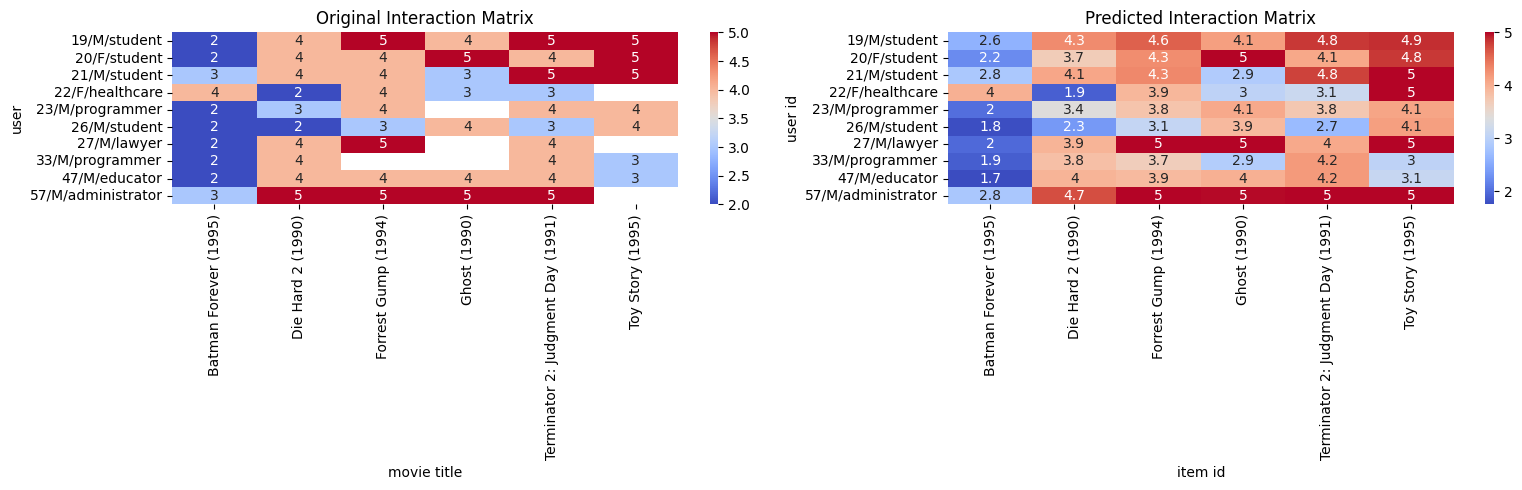

In [153]:
# 원래 상호작용행렬과 예측한 상호작용행렬을 Heat을 사용하여 표시합니다.
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.heatmap(
    df_interaction,
    annot=True, cmap=cmap_coolwarm,
    ax=axes[0]
)
axes[0].set_title('Original Interaction Matrix')

sns.heatmap(
    df_ratings_toy_prd.clip(1, 5),
    annot=True, cmap=cmap_coolwarm,
    ax=axes[1]
)
axes[1].set_title('Predicted Interaction Matrix')

plt.tight_layout()
plt.show()

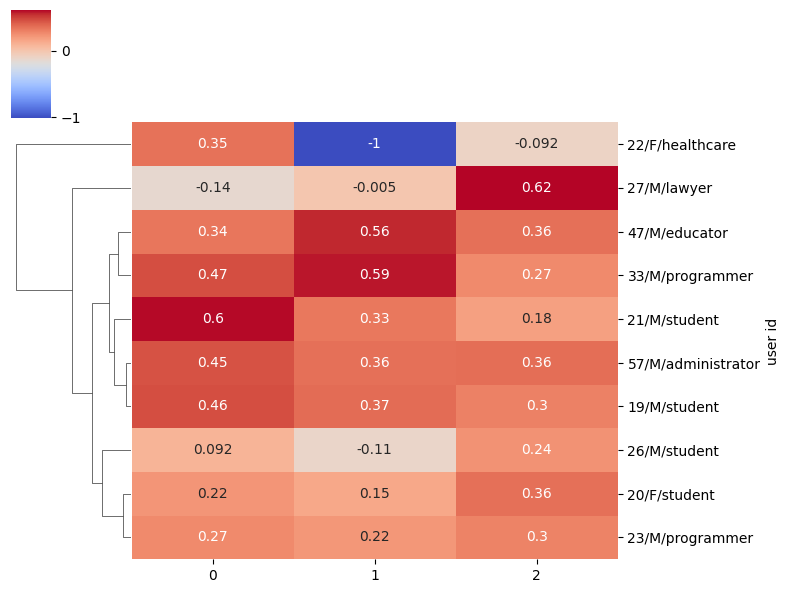

In [154]:
sns.clustermap(
    df_user_emb,
    annot=True, cmap=cmap_coolwarm,
    col_cluster=False,
    figsize=(8,6),
)
plt.show()

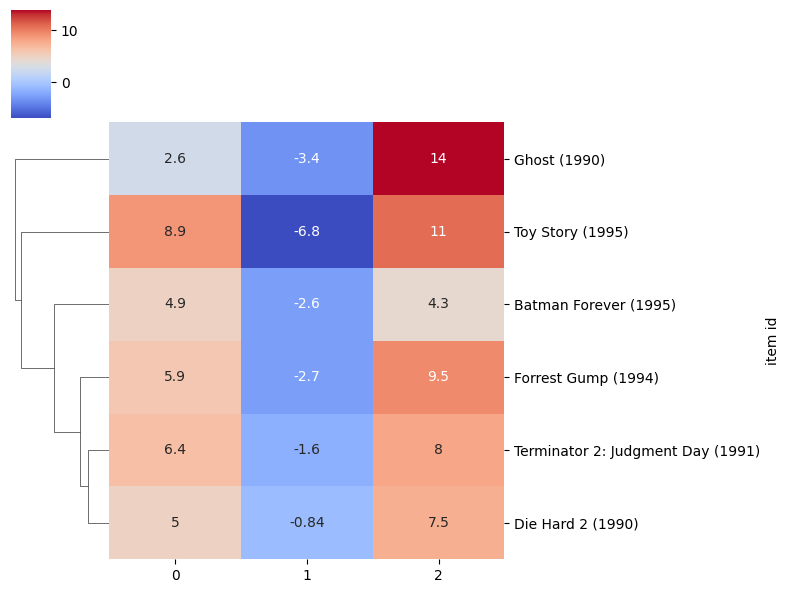

In [155]:
sns.clustermap(
    df_item_emb,
    annot=True, cmap=cmap_coolwarm,
    col_cluster=False,
    figsize=(8,6),
)
plt.show()

### 경사하강법(Gradient Descent)

$\hat{y} = User × Item^T$

$Loss = \frac{1}{n}\sum_{i=1}^{n}{\left(y_i - \hat{y}_i\right)^2}$

$\frac{dLoss}{dUser_u} = -\frac{2}{n_u}\sum_{j∈u's Rating}{\left(y_{j} - \hat{y}_{j}\right)Item_j}$

$\frac{dLoss}{dItem_i} = -\frac{2}{n_i}\sum_{j∈i's Rating}{\left(y_{j} - \hat{y}_{j}\right)User_j}$

(1) 사용자 / 아이템 임베딩 초기화

(2-1) 경사도 계산

(2-2) 임베딩 업데이트

(3) (2)과정 반복

In [156]:
# Step 1: 임베딩을 초기화 합니다.
Rank = 3 # 랭크는 3으로 합니다.
learning_rate = 0.1 # 학습율은 0.1로 합니다.

np.random.seed(123)
df_user_emb = pd.DataFrame(np.random.random(size=(len(user_index), Rank)) * 1 / np.sqrt(Rank), index=user_index)
df_item_emb = pd.DataFrame(np.random.random(size=(len(item_index), Rank)) * 1 / np.sqrt(Rank), index=item_index)

In [157]:
# Step 2-1: 경사(기울기)를 계산합니다.

X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])
X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])
y_hat = (X_user * X_item).sum(axis=1)
err = df_ratings_toy['rating'] - y_hat

X_user_g = -X_item.groupby(df_ratings_toy['user id']).apply(lambda x: err.loc[x.index].dot(x) / len(x))
X_item_g = -X_user.groupby(df_ratings_toy['item id']).apply(lambda x: err.loc[x.index].dot(x) / len(x))

In [158]:
# Step 2-2: 계산한 경사로 임베딩을 업데이트 합니다.

df_user_emb -= X_user_g * learning_rate
df_item_emb -= X_item_g * learning_rate

* 1~3 과정을 통합하여 루틴을 구성합니다.

In [159]:
# Step 1
Rank = 3
learning_rate = 0.1

np.random.seed(123)
df_user_emb = pd.DataFrame(np.random.random(size=(len(user_index), Rank)) * 1 / np.sqrt(Rank), index=user_index)
df_item_emb = pd.DataFrame(np.random.random(size=(len(item_index), Rank)) * 1 / np.sqrt(Rank), index=item_index)

# Step 3
for epoch in range(10):
    # Step 2-1

    X_user = df_ratings_toy['user id'].apply(lambda x: df_user_emb.loc[x])
    X_item = df_ratings_toy['item id'].apply(lambda x: df_item_emb.loc[x])
    y_hat = (X_user * X_item).sum(axis=1)
    err = df_ratings_toy['rating'] - y_hat

    X_user_g = -X_item.groupby(df_ratings_toy['user id']).apply(lambda x: err.loc[x.index].dot(x) / len(x))
    X_item_g = -X_user.groupby(df_ratings_toy['item id']).apply(lambda x: err.loc[x.index].dot(x) / len(x))
    
    # Step 2-2

    df_user_emb -= X_user_g * learning_rate
    df_item_emb -= X_item_g * learning_rate
    
    mse = mean_squared_error(df_ratings_toy['rating'], (X_user * X_item).sum(axis=1))
    print(epoch + 1, mse)
    

1 12.87593584638023
2 11.399391257847347
3 9.14388319743434
4 6.166902892702463
5 3.16990249043531
6 1.2077269647872506
7 0.4933619140350706
8 0.3503577516496221
9 0.3266633838208615
10 0.3202640840737094


In [160]:
df_user_emb.index = df_user_emb.index.map(df_user[['age', 'gender', 'occupation']].astype('str').apply(lambda x: '/'.join(x), axis=1))
df_item_emb.index = df_item_emb.index.map(df_movie['movie title'])

In [161]:
df_ratings_toy_prd = df_user_emb.dot(df_item_emb.T)
df_ratings_toy_prd = df_ratings_toy_prd.sort_index().sort_index(axis=1)

In [162]:
df_ratings_toy_prd = df_user_emb.dot(df_item_emb.T)
df_ratings_toy_prd = df_ratings_toy_prd.sort_index().sort_index(axis=1)
df_ratings_toy_prd.clip(1, 5).sort_index().sort_index(axis=1)

,Batman Forever (1995),Die Hard 2 (1990),Forrest Gump (1994),Ghost (1990),Terminator 2: Judgment Day (1991),Toy Story (1995)
user id,,,,,,
19/M/student,2.716405,4.068654,4.703102,4.334431,4.646584,4.713234
20/F/student,2.606136,3.891015,4.506182,4.151972,4.465383,4.521616
21/M/student,2.558320,3.915106,4.456050,4.203052,4.436959,4.493667
22/F/healthcare,2.019236,3.058265,3.508127,3.263914,3.468469,3.520906
23/M/programmer,2.262143,3.286764,3.880409,3.483586,3.825864,3.872887
26/M/student,1.916875,2.952413,3.346377,3.167918,3.325775,3.373424
27/M/lawyer,2.548888,3.789602,4.402106,4.037540,4.355537,4.411756
33/M/programmer,2.136337,3.300556,3.733666,3.539983,3.706348,3.762670
47/M/educator,2.238742,3.431784,3.898787,3.700608,3.907196,3.945820


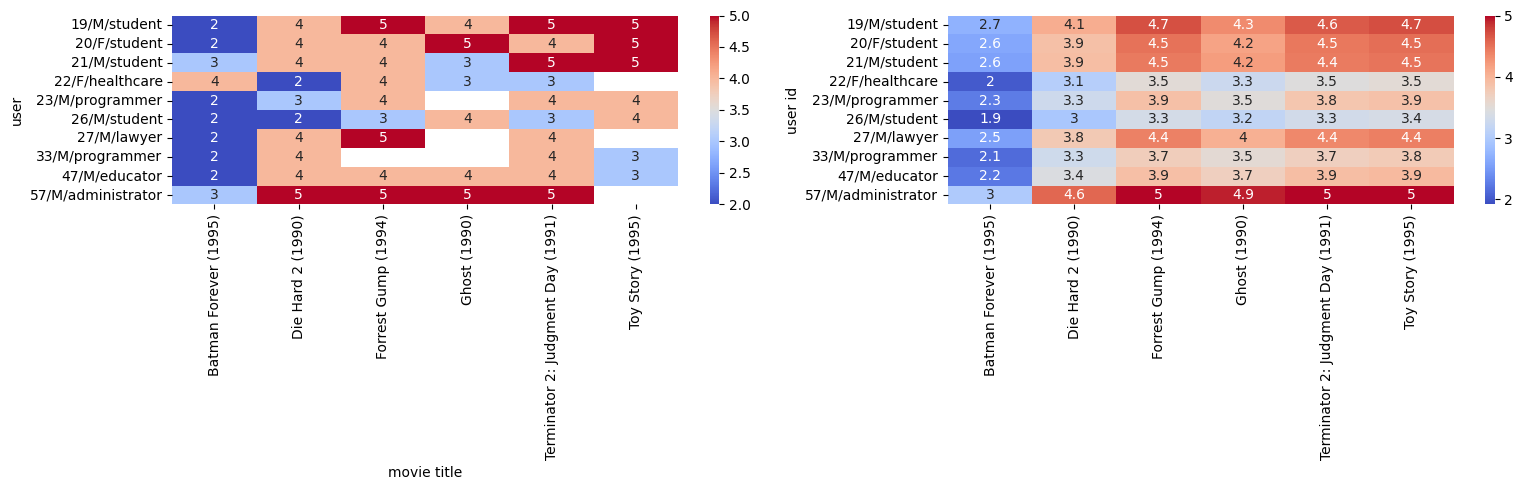

In [163]:
# 원래값과 예측값을 비교합니다.

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.heatmap(
    df_interaction,
    annot=True, cmap=cmap_coolwarm,
    ax=axes[0]
)

sns.heatmap(
    df_ratings_toy_prd.clip(1, 5),
    annot=True, cmap=cmap_coolwarm,
    ax=axes[1]
)

plt.tight_layout()
plt.show()

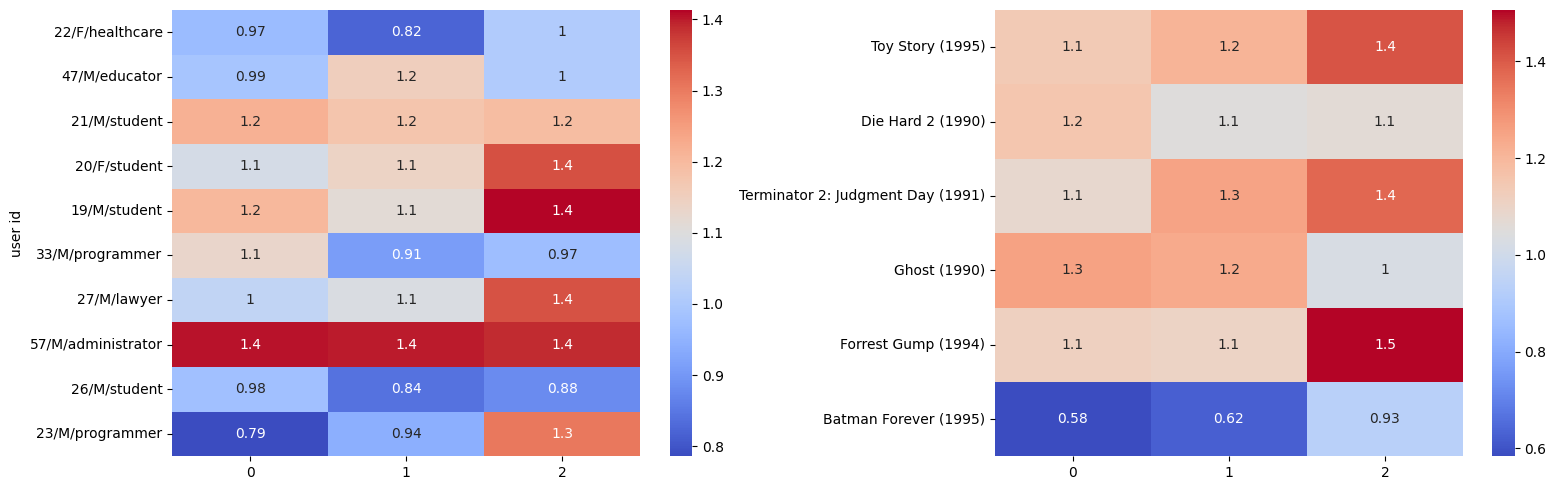

In [164]:
# 임베딩을 출력합니다.

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.heatmap(
    df_user_emb,
    annot=True, cmap=cmap_coolwarm,
    ax=axes[0]
)

sns.heatmap(
    df_item_emb,
    annot=True, cmap=cmap_coolwarm,
    ax=axes[1]
)

plt.tight_layout()
plt.show()

## Tensorflow로 MovieLens100K 학습하기

$\hat{r}_{ui} = \bar{r} + \bar{r_u} + \bar{r_i} + ue_u \cdot ie_i$

$\bar{r_u}$: 사용자의 상대적 평균(다른 사용자에 비해 평균적으로 평점을 얼마나 많이 주는지 나타냅니다.

$\bar{r_i}$: 아이템의 상대적 평균(다른 아이템에 비해 평균적으로 평점을 얼마나 많이 주는지 나타냅니다.

ue: User Embedding, ie: Item Embedding

In [165]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorboard.plugins import projector
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [166]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print("{} Physical GPUs, {} Logical GPUs".format(len(gpus), len(logical_gpus)))
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [167]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df_ratings, train_size=0.8, random_state=123, shuffle=True)

In [168]:
df_train['user id'].value_counts()

user id
405    593
655    537
13     489
450    443
276    423
      ... 
876     14
812     14
685     14
147     14
866     13
Name: count, Length: 943, dtype: int64

In [169]:
ds_train = tf.data.Dataset.from_tensor_slices(
    ({i: df_train[i] for i in ['item id', 'user id']}, df_train['rating'])
)

ds_test = tf.data.Dataset.from_tensor_slices(
    ({i: df_test[i] for i in ['item id', 'user id']}, df_test['rating'])
)

In [170]:
for X, y in ds_train.batch(32).take(1):
    print(X, y)

{'item id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([  24,  511,  746,  196,   83,  632,  478,  387,  208, 1111,  654,
        400,  752,  425,  161,   69,  653,  117,  393,  183,  357,  281,
        118,  975,  529,  216,  100,  234,  354,   79,  313,   12])>, 'user id': <tf.Tensor: shape=(32,), dtype=int64, numpy=
array([429, 480, 916, 892,  90, 144, 465, 301, 437, 758, 292, 254, 782,
       406, 851, 663, 303, 320, 291, 767,  16, 406, 213, 560, 325, 327,
       383, 833, 695, 454, 332, 543])>} tf.Tensor([3 4 3 4 5 4 4 3 5 4 5 3 4 3 3 4 4 4 3 4 5 3 4 3 4 3 4 3 4 4 5 5], shape=(32,), dtype=int64)


**Matrix Factorization**

In [171]:
# Live Coding

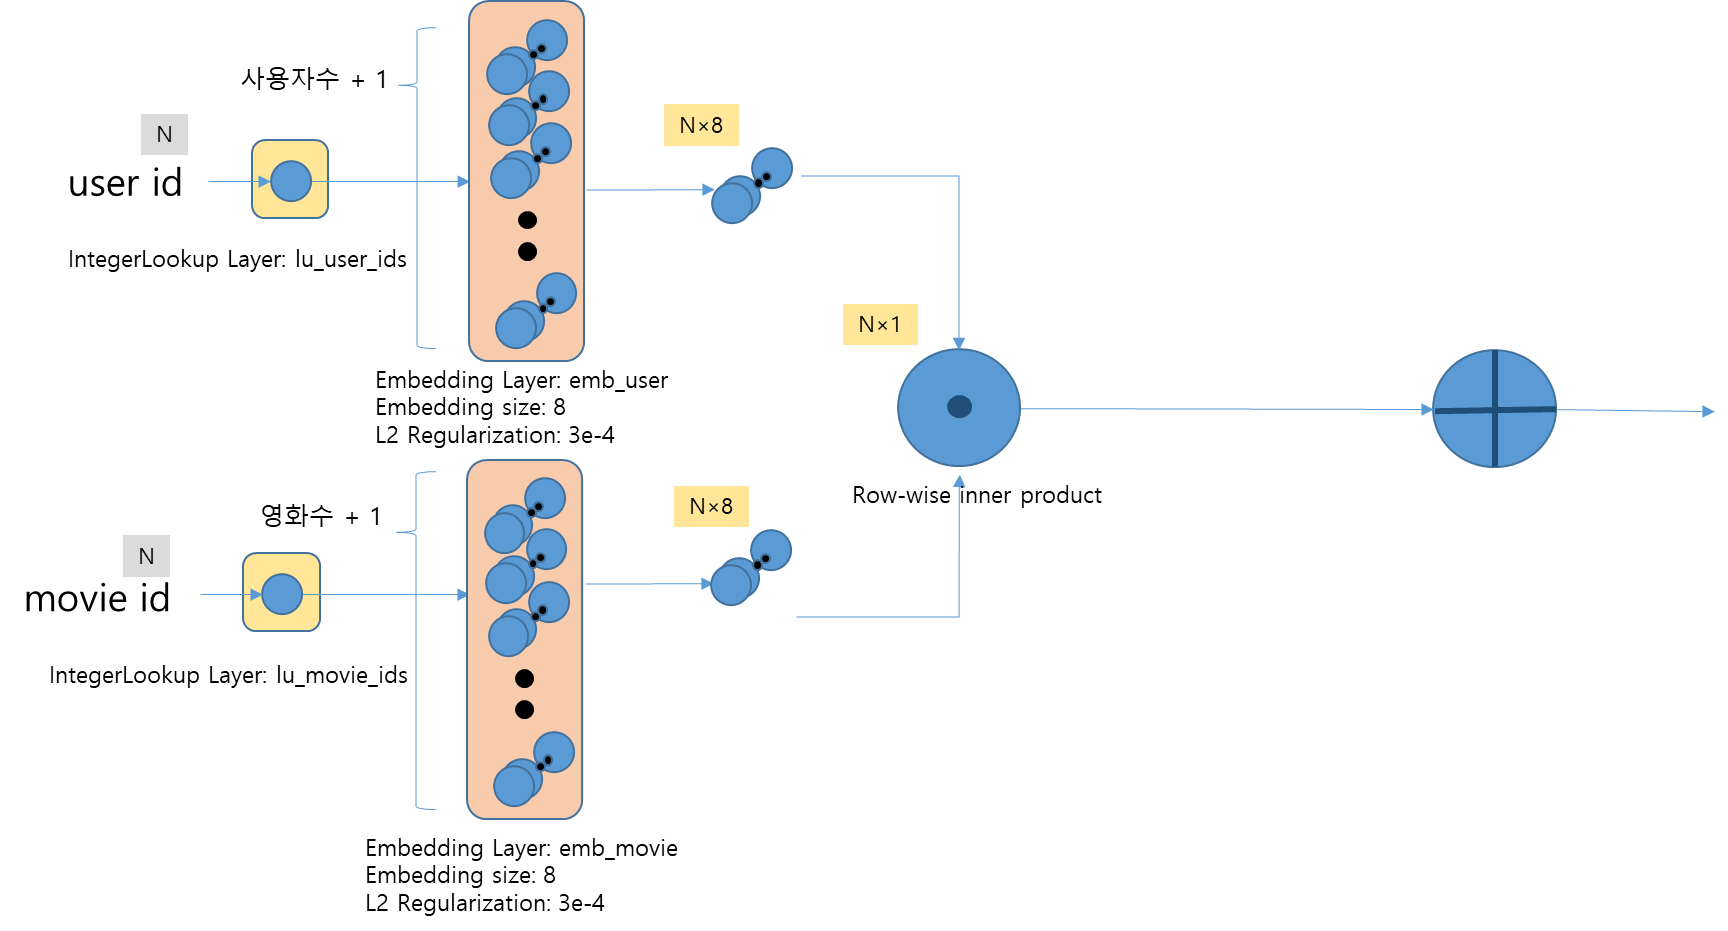

**Mean Model**

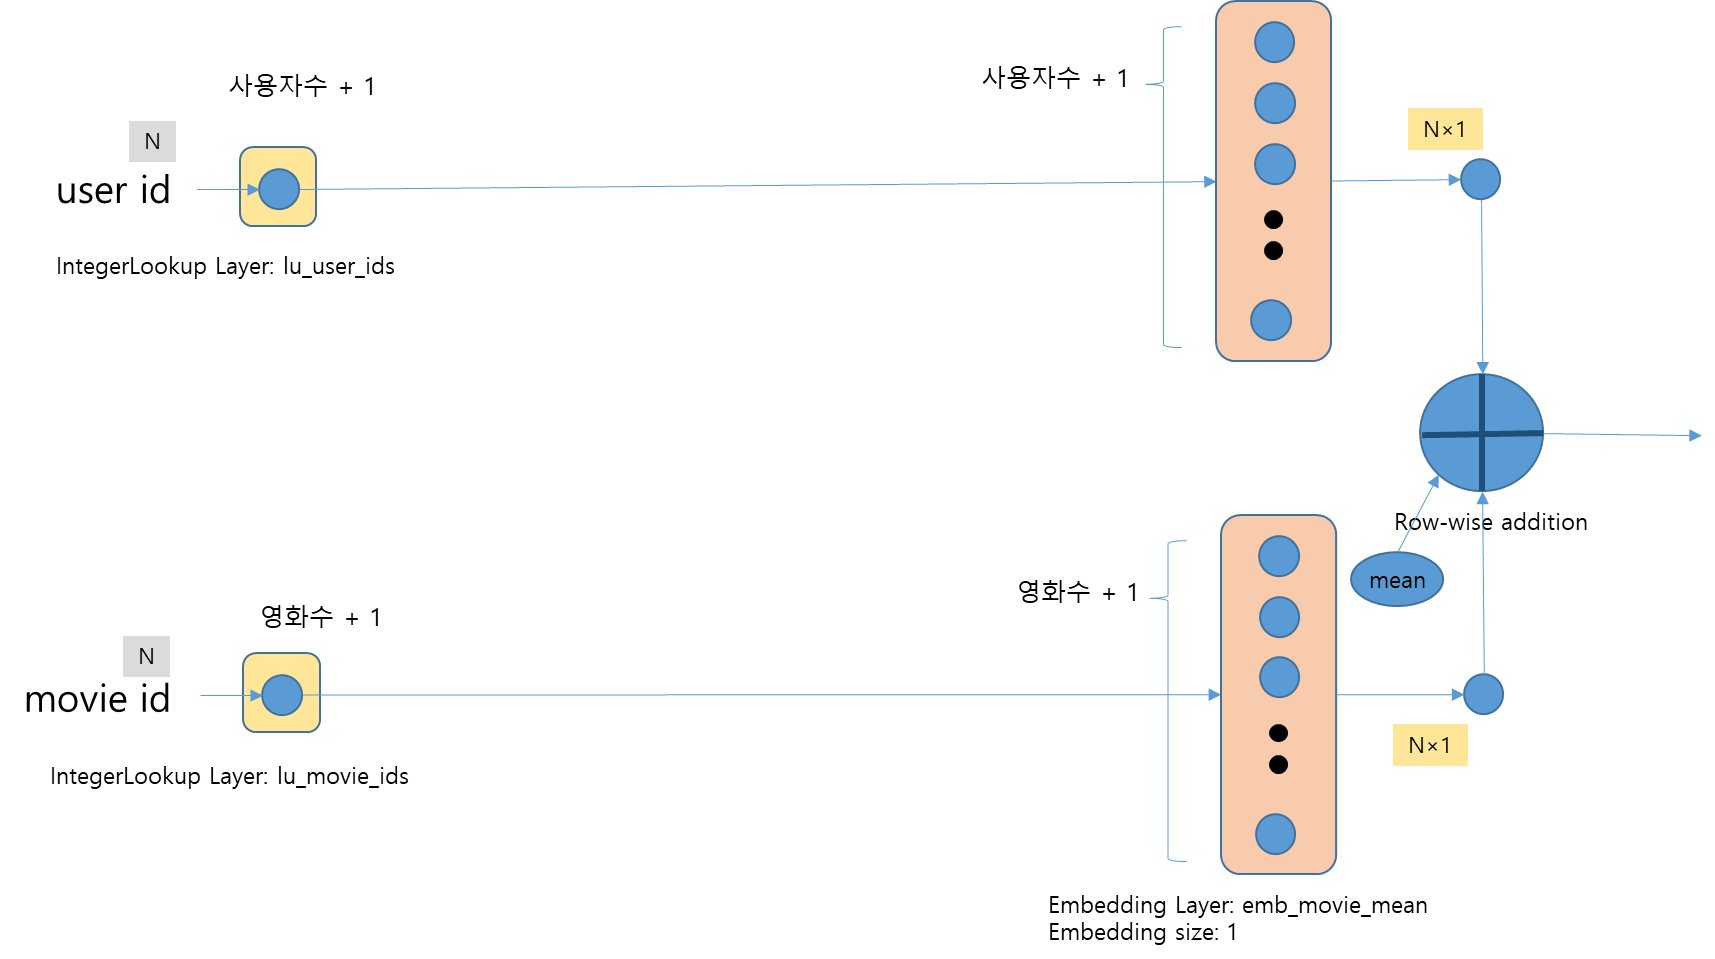

In [172]:
# Live Coding

**Matrix Factorization augumented user/item mean Model Architecture**

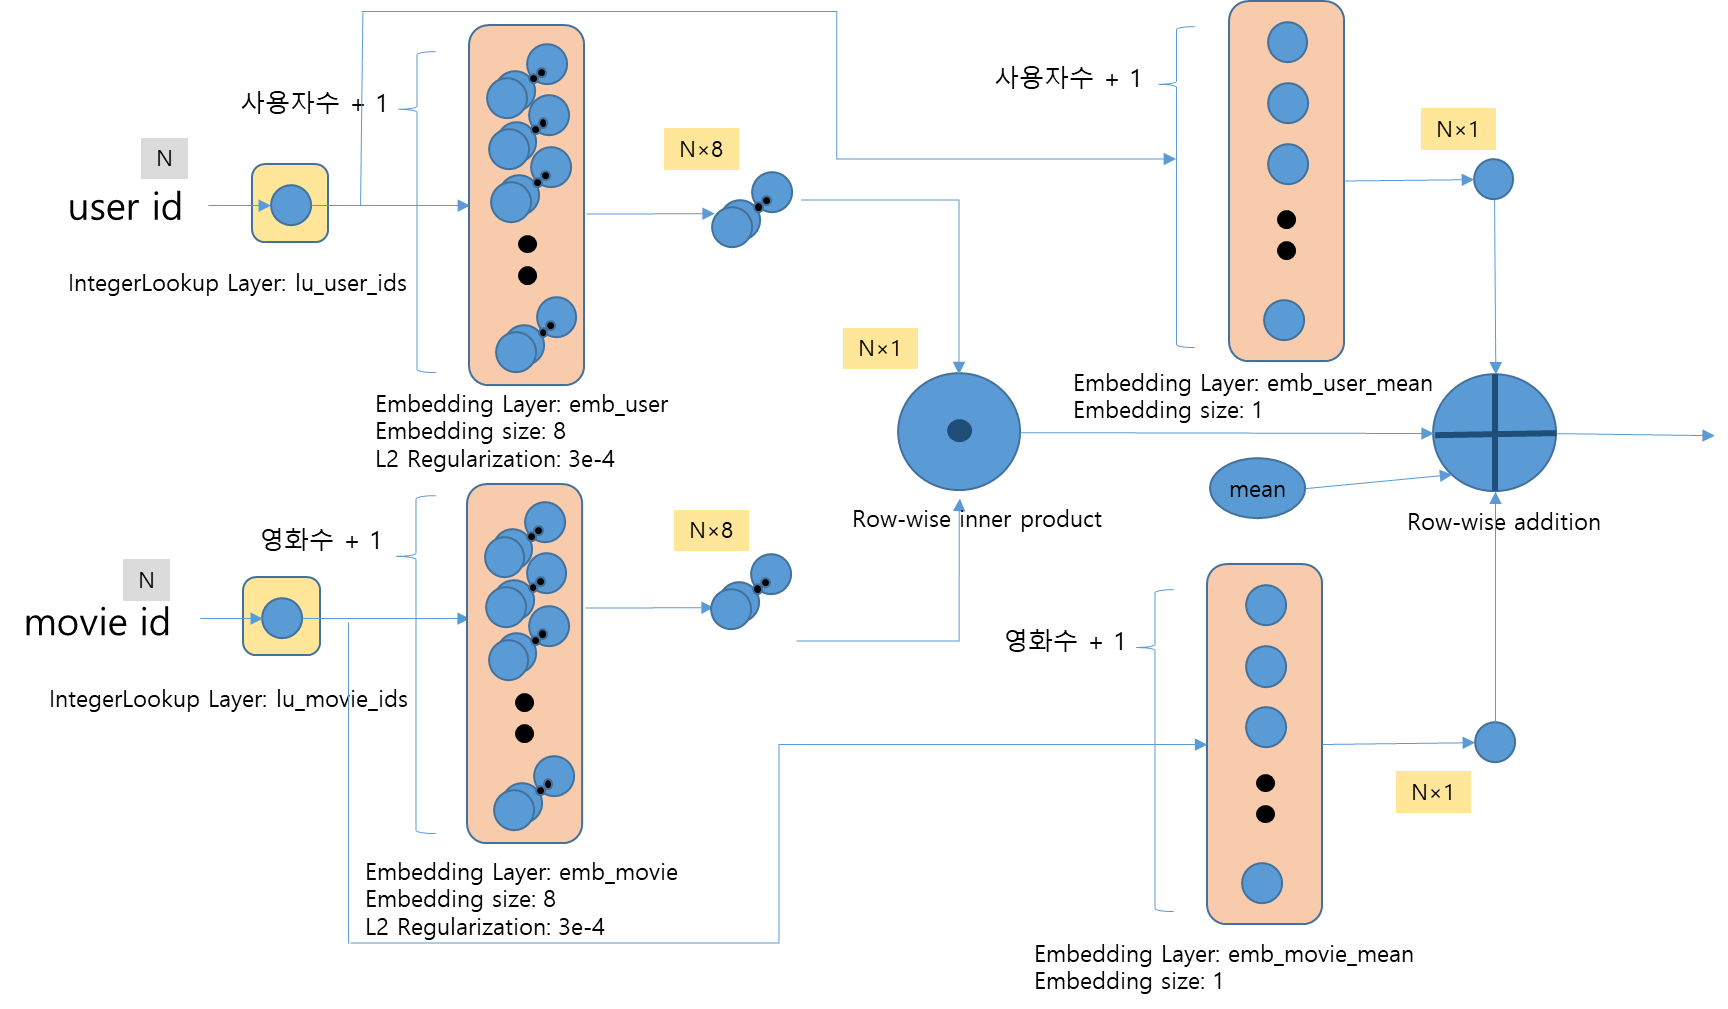

In [173]:
class MF_Mean_Model(tf.keras.Model):
    def __init__(self, mean, user_ids, item_ids, rank):
        super().__init__()
        self.mean = tf.constant([mean], dtype=tf.float32)
        
        # user id들을 사전으로 구성하고 user id를 입력을 받아 이를 1부터 시작하는 인덱스로 변환해주는 Layer를 생성합니다. OOV: 0
        self.lu_user = tf.keras.layers.IntegerLookup(vocabulary=user_ids)
        # item id들을 사전으로 구성하고 user id를 입력을 받아 이를 1부터 시작하는 인덱스로 변환해주는 Layer를 생성합니다. OOV: 0
        self.lu_item = tf.keras.layers.IntegerLookup(vocabulary=item_ids)
        
        # user id에 대한 상대적 평균을 나타내는 임베딩입니다.
        self.emb_user_mean = tf.keras.layers.Embedding(len(user_ids) + 1, 1)
        # item id에 대한 상대적 평균을 나타내는 임베딩입니다. 
        self.emb_item_mean = tf.keras.layers.Embedding(len(item_ids) + 1, 1)
        
        # 사용자 행렬을 나타내는 사용자 임베딩입니다. embedding_regularizer를 두어 Overfitting을 방지합니다.
        self.emb_user = tf.keras.layers.Embedding(len(user_ids) + 1, rank, embeddings_regularizer=tf.keras.regularizers.L2(1.5e-4))
        # 아이템 행렬을 나타내는 아이템 임베딩입니다. embedding_regularizer를 두어 Overfitting을 방지합니다.
        self.emb_item = tf.keras.layers.Embedding(len(item_ids) + 1, rank, embeddings_regularizer=tf.keras.regularizers.L2(1.5e-4))
        
        # 맵핑된 사용자 임베딩과 맵핑된 아이템 임베딩을 Row-wise inner product 연산을 해주는 layer입니다. 
        self.dot = tf.keras.layers.Dot(axes=-1)
        
    def call(self, x, training=False):
        x_user = self.lu_user(x['user id']) # 사용자 ID에서 임베딩 인덱스로 변환합니다. X['user id'] N×1 정수 / x_user: N×1 정수
        user_vec = self.emb_user(x_user) # 사용자 임베딩을 가져옵니다. user_vec: N×rank 실수
        user_mean = self.emb_user_mean(x_user) # 사용자의 상대적 평균을 가져옵니다. user_mean: N×1 실수
        
        x_item = self.lu_item(x['item id']) # 아이템 ID에서 임베딩 인덱스로 변환합니다. X['item id'] N×1 정수 / x_movie: N×1 정수
        item_vec = self.emb_item(x_item) # 아이템 임베딩을 가져옵니다. user_vec: N×rank 실수
        item_mean = self.emb_item_mean(x_item) # 아이템의 상대적 평균을 가져옵니다.
        
        return self.mean + user_mean + item_mean + self.dot([user_vec, item_vec])
    
    def predict_by_userid(self, user_id, item_ids):
        x_user = self.lu_user(user_id) # 사용자 ID에서 임베딩 인덱스로 변환합니다. X['user id'] 단일 정수 / x_user: 단일 정수 정수
        user_vec = self.emb_user(x_user) # 사용자 임베딩을 가져옵니다. emb_user: rank개의 실수
        
        x_item = self.lu_item(item_ids) # 아이템 ID에서 임베딩 인덱스로 변환합니다. X['item id'] N개의 정수 / x_item: N개의 정수
        return tf.squeeze(
            tf.matmul(
                tf.expand_dims(user_vec, axis=0), 
                tf.transpose(self.emb_item(x_item))
            ) + 
            tf.squeeze(
                self.emb_item_mean(x_item)
            ) + 
            self.emb_user_mean(x_user) +
            self.mean
        )

In [174]:
mf_mean_model = MF_Mean_Model(
    df_train['rating'].mean(),
    df_train['user id'].value_counts().pipe(lambda x: x.loc[x > 20]).index.values, # train에서 20회 넘게 등장한 사용자 ID를 전달합니다. 
    df_train['item id'].value_counts().pipe(lambda x: x.loc[x > 20]).index.values, # train에서 20회 넘게 등장한 아이템 ID를 전달합니다.
    16
)

In [175]:
tf.keras.backend.clear_session()
mf_mean_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.004), # Adam Optimizer를 사용합니다.
    loss=tf.keras.losses.MeanSquaredError(), # 손실은 MSE를 사용합니다.
    metrics=tf.keras.metrics.MeanSquaredError() # 지표는 MSE로 합니다.
)

In [176]:
mf_mean_model.fit(ds_train.shuffle(100000).batch(256), validation_data=ds_test.batch(256), epochs=20)

Epoch 1/20
313/313 [==============================] - 6s 16ms/step - loss: 1.0764 - mean_squared_error: 1.0654 - val_loss: 0.9987 - val_mean_squared_error: 0.9738
Epoch 2/20
313/313 [==============================] - 2s 5ms/step - loss: 0.9276 - mean_squared_error: 0.8917 - val_loss: 0.9491 - val_mean_squared_error: 0.9089
Epoch 3/20
313/313 [==============================] - 1s 4ms/step - loss: 0.8832 - mean_squared_error: 0.8367 - val_loss: 0.9286 - val_mean_squared_error: 0.8808
Epoch 4/20
313/313 [==============================] - 1s 4ms/step - loss: 0.8630 - mean_squared_error: 0.8113 - val_loss: 0.9215 - val_mean_squared_error: 0.8701
Epoch 5/20
313/313 [==============================] - 1s 4ms/step - loss: 0.8518 - mean_squared_error: 0.7967 - val_loss: 0.9186 - val_mean_squared_error: 0.8636
Epoch 6/20
313/313 [==============================] - 1s 4ms/step - loss: 0.8443 - mean_squared_error: 0.7849 - val_loss: 0.9190 - val_mean_squared_error: 0.8585
Epoch 7/20
313/313 [=======

In [177]:
# 영화 임베딩을 3차원 공간에 투영하여 학습된 임베딩의 특성을 확인해봅니다.
import os

log_dir='logs/m100k/'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# TSV로 만들면 영화 타이트을 투영시 보이게 할 수 있습니다.
with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for i in df_train['item id'].value_counts().pipe(lambda x: x.loc[x > 20]).index:
        f.write("{}\n".format(df_movie.loc[i, 'movie title']))

# 영화의 임베딩을 기록합니다.
weights =  tf.Variable(mf_mean_model.emb_item.get_weights()[0][1:])
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

# 프로젝터를 설정합니다.
config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [178]:
%tensorboard --logdir logs/m100k/ --bind_all

Reusing TensorBoard on port 6006 (pid 4127), started 0:40:37 ago. (Use '!kill 4127' to kill it.)

In [102]:
!ps -ef | grep tensorboard

sun9sun9    4451     477 20 15:09 ?        00:00:10 /usr/bin/python /home/sun9sun9/.local/bin/tensorboard --logdir logs/m100k/ --bind_all
sun9sun9    4517    4451  0 15:09 ?        00:00:00 /home/sun9sun9/.local/lib/python3.10/site-packages/tensorboard_data_server/bin/server --logdir=logs/m100k/ --reload=5 --samples-per-plugin= --port=0 --port-file=/tmp/tensorboard_data_server_9epnmc3x/port --die-after-stdin --error-file=/tmp/tensorboard_data_server_9epnmc3x/startup_error
sun9sun9    4651     477  0 15:09 pts/2    00:00:00 /bin/bash -c ps -ef | grep tensorboard
sun9sun9    4653    4651  0 15:09 pts/2    00:00:00 grep tensorboard


In [103]:
!kill 4451

In [105]:
mf_model.predict_by_userid(1, [1, 2, 3])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([3.6988547, 3.2942445, 2.985447 ], dtype=float32)>

## NNModel

**Neural Networks Architecture**

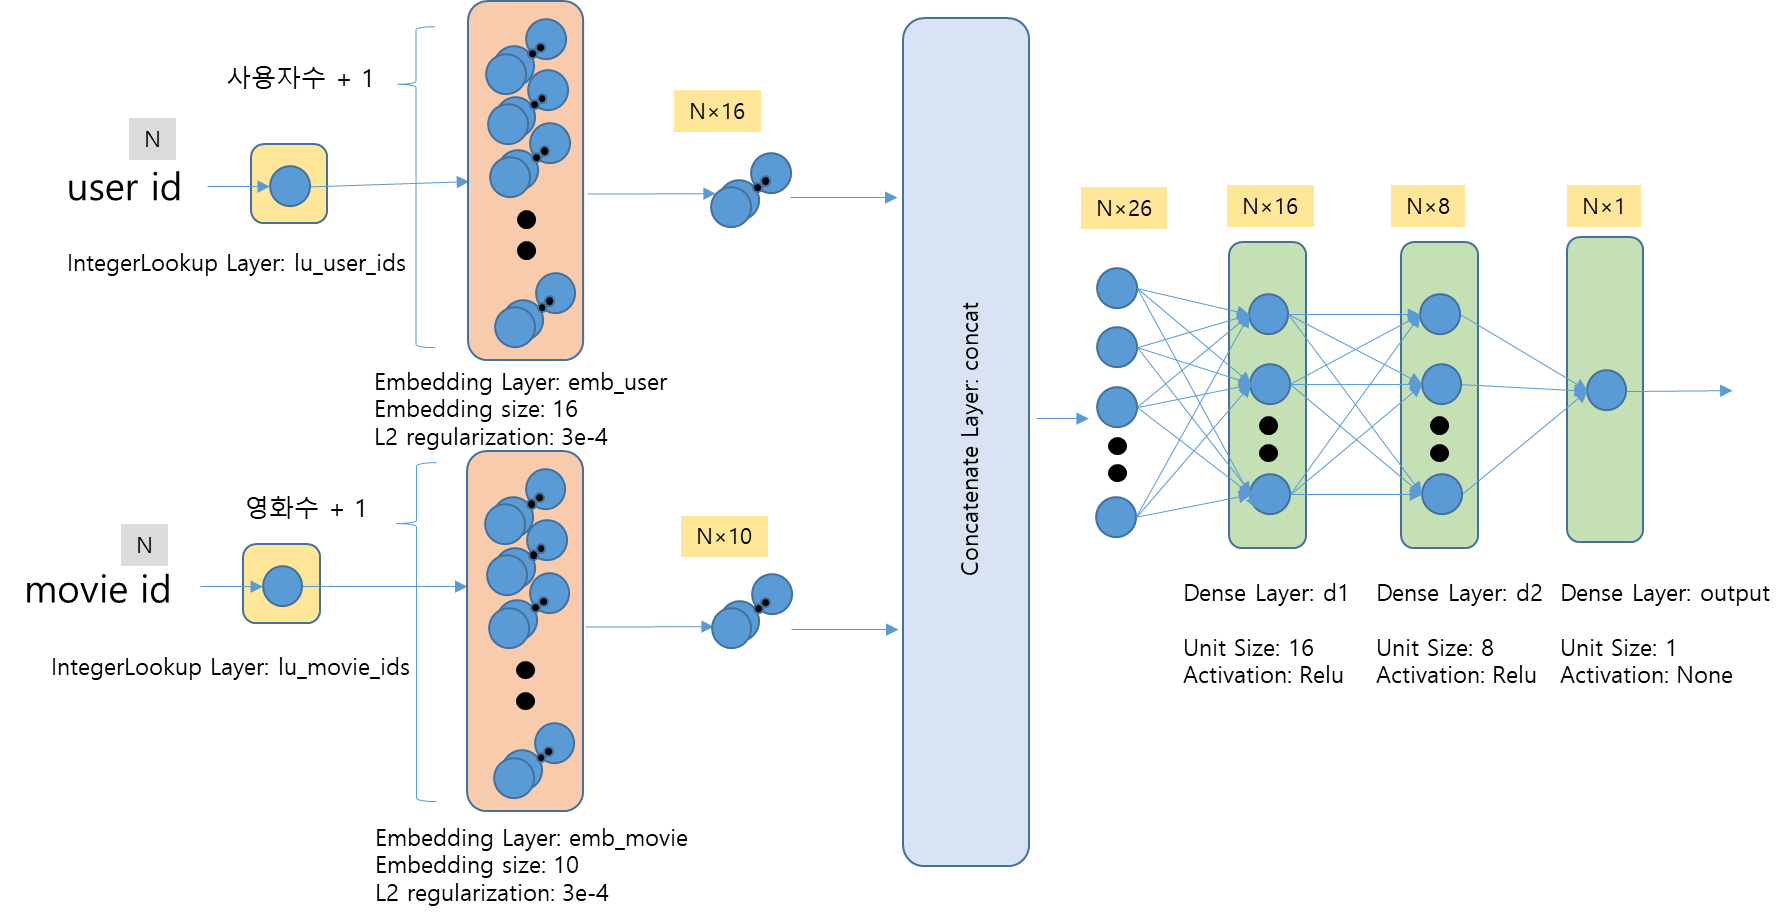

In [116]:
class NNModel(tf.keras.Model):
    def __init__(self, user_ids, item_ids, emb_user_size, emb_item_size):
        super().__init__()
        self.lu_user = tf.keras.layers.IntegerLookup(vocabulary=user_ids)
        self.lu_item = tf.keras.layers.IntegerLookup(vocabulary=item_ids)
        
        self.emb_user =  tf.keras.layers.Embedding(len(user_ids) + 1, emb_user_size)
        self.emb_item =  tf.keras.layers.Embedding(len(item_ids) + 1, emb_item_size)
        
        self.cc = tf.keras.layers.Concatenate(axis=-1)
        
        self.dl1 = tf.keras.layers.Dense(16, activation='relu')
        self.dl2 = tf.keras.layers.Dense(8, activation='relu')
        self.o = tf.keras.layers.Dense(1)
        
    def call(self, x, training=False):
        x_user = self.lu_user(x['user id'])
        x_user = self.emb_user(x_user)
        x_item = self.lu_item(x['item id'])
        x_item = self.emb_item(x_item)
        y = self.cc([x_user, x_item])
        y = self.dl1(y)
        y = self.dl2(y)
        return self.o(y)

In [120]:
nn_model = NNModel(
    df_train['user id'].pipe(lambda x: x.loc[x > 20]).index.values, 
    df_train['item id'].pipe(lambda x: x.loc[x > 20]).index.values, 16, 10
)

In [121]:
tf.keras.backend.clear_session()
nn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=tf.keras.metrics.MeanSquaredError()
)
nn_model.fit(ds_train.shuffle(10000).batch(256), validation_data=ds_test.batch(1024), epochs=30)

Epoch 1/30


2023-11-19 15:26:34.441079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [80000]
	 [[{{node Placeholder/_2}}]]
2023-11-19 15:26:34.441380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int64 and shape [80000]
	 [[{{node Placeholder/_0}}]]


313/313 [==============================] - 13s 38ms/step - loss: 13.4596 - mean_squared_error: 13.4596 - val_loss: 13.0709 - val_mean_squared_error: 13.0709
Epoch 2/30


2023-11-19 15:26:47.310978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [20000]
	 [[{{node Placeholder/_2}}]]


313/313 [==============================] - 4s 11ms/step - loss: 12.1487 - mean_squared_error: 12.1487 - val_loss: 10.8751 - val_mean_squared_error: 10.8751
Epoch 3/30
313/313 [==============================] - 3s 9ms/step - loss: 8.6953 - mean_squared_error: 8.6953 - val_loss: 6.2605 - val_mean_squared_error: 6.2605
Epoch 4/30
313/313 [==============================] - 3s 8ms/step - loss: 4.0983 - mean_squared_error: 4.0983 - val_loss: 2.5122 - val_mean_squared_error: 2.5122
Epoch 5/30
313/313 [==============================] - 2s 7ms/step - loss: 1.9096 - mean_squared_error: 1.9096 - val_loss: 1.5878 - val_mean_squared_error: 1.5878
Epoch 6/30
313/313 [==============================] - 2s 7ms/step - loss: 1.4092 - mean_squared_error: 1.4092 - val_loss: 1.3049 - val_mean_squared_error: 1.3049
Epoch 7/30
313/313 [==============================] - 2s 7ms/step - loss: 1.1986 - mean_squared_error: 1.1986 - val_loss: 1.1622 - val_mean_squared_error: 1.1622
Epoch 8/30
313/313 [==============

**VS Neural Network**

* Matrix Factorization은 Neural Network 보다 서비스 시 더 빠릅니다.

**Matrix Factorization**: 사용자 한 명의 영화에 대한 예측은 한 번의 모델 실행으로 구할 수 있습니다.

※ Google에서 개발한 ScaNN과 같은 알고리즘 이 과정을 보다 최적화시켜 줍니다.

In [125]:
%%timeit
mf_model.predict_by_userid(1,  tf.constant(df_movie.index))

4.64 ms ± 582 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Neural Network**: 사용자 한 명의 영화에 대한 예측을 구하려면 예측할 영화의 개수 만큼 모델을 실행해야 합니다.

In [126]:
%%timeit
X = tf.data.Dataset.from_tensor_slices({
    'user id': [1] * len(df_movie),
    'item id': df_movie.index.tolist()
}).batch(2048)

nn_model.predict(X, verbose=0)

2023-11-19 15:29:53.102338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [1682]
	 [[{{node Placeholder/_1}}]]
2023-11-19 15:29:53.185038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [1682]
	 [[{{node Placeholder/_1}}]]
2023-11-19 15:29:53.210119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int32 and shape [1682]
	

25.3 ms ± 2.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


* 하지만 구조상 User와 Item 을 동일한 수의 임베딩으로 모델링해야 한다는 구조적 제약이 있어 Neural Network 보다는 모델 유연한 구성이 힘듭니다

# 문제점

Matrix Factorization 모델 뿐만 아니라, 데이터 기반의 방법에서의 문제점이기도 합니다.

## 1. Cold Start Problem

데이터가 확보되지 않은 사용자나 아이템에 대한 예측의 정확도가 떨어집니다.

In [127]:
# 시점을 기준으로 나누어 Test에는 Train에 등장하지 않은 사용자와 영화가 배치되도록 합니다.
df_train = df_ratings.query('date < "1998-03-01"')
df_test = df_ratings.query('date >= "1998-03-01"')

ds_train = tf.data.Dataset.from_tensor_slices(
    ({i: df_train[i] for i in ['item id', 'user id']}, df_train['rating'])
)

ds_test = tf.data.Dataset.from_tensor_slices(
    ({i: df_test[i] for i in ['item id', 'user id']}, df_test['rating'])
)

In [128]:
# Train에 등장하지 않은 사용자의 출연 빈도를 봅니다.
df_test['user id'].value_counts().pipe(lambda x: x.loc[~x.isin(df_train['user id'].unique())])

user id
234    480
796    358
551    334
334    333
393    234
      ... 
661      3
577      3
561      3
483      3
453      3
Name: count, Length: 75, dtype: int64

In [132]:
mf_model = MFModel(
    df_train['rating'].mean(),
    df_train['user id'].value_counts().pipe(lambda x: x.loc[x > 20]).index.values, 
    df_train['item id'].value_counts().pipe(lambda x: x.loc[x > 20]).index.values, 16
)
tf.keras.backend.clear_session()
mf_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.004),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=tf.keras.metrics.MeanSquaredError()
)

In [133]:
mf_model.fit(ds_train.shuffle(100000).batch(256), validation_data=ds_test.batch(1024), epochs=20)

Epoch 1/20


2023-11-19 15:31:27.677287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [77985]
	 [[{{node Placeholder/_2}}]]
2023-11-19 15:31:27.677552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype int64 and shape [77985]
	 [[{{node Placeholder/_1}}]]


305/305 [==============================] - 11s 34ms/step - loss: 1.0658 - mean_squared_error: 1.0542 - val_loss: 1.1589 - val_mean_squared_error: 1.1310
Epoch 2/20


2023-11-19 15:31:38.962235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [22015]
	 [[{{node Placeholder/_2}}]]


305/305 [==============================] - 4s 12ms/step - loss: 0.9125 - mean_squared_error: 0.8747 - val_loss: 1.1723 - val_mean_squared_error: 1.1284
Epoch 3/20
305/305 [==============================] - 3s 9ms/step - loss: 0.8690 - mean_squared_error: 0.8192 - val_loss: 1.1576 - val_mean_squared_error: 1.1069
Epoch 4/20
305/305 [==============================] - 2s 7ms/step - loss: 0.8487 - mean_squared_error: 0.7943 - val_loss: 1.1749 - val_mean_squared_error: 1.1193
Epoch 5/20
305/305 [==============================] - 2s 7ms/step - loss: 0.8365 - mean_squared_error: 0.7766 - val_loss: 1.1676 - val_mean_squared_error: 1.1067
Epoch 6/20
305/305 [==============================] - 2s 7ms/step - loss: 0.8283 - mean_squared_error: 0.7623 - val_loss: 1.1727 - val_mean_squared_error: 1.1051
Epoch 7/20
305/305 [==============================] - 2s 7ms/step - loss: 0.8212 - mean_squared_error: 0.7476 - val_loss: 1.1783 - val_mean_squared_error: 1.1034
Epoch 8/20
305/305 [==================

In [134]:
s_mse = df_test.assign(
    rating_hat = np.squeeze(mf_model.predict(ds_test.batch(1024)))
).groupby('user id').apply(lambda x: mean_squared_error(x['rating'], x['rating_hat'])).rename('mse')

22/22 [==============================] - 0s 2ms/step


2023-11-19 15:32:22.139601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int64 and shape [22015]
	 [[{{node Placeholder/_2}}]]


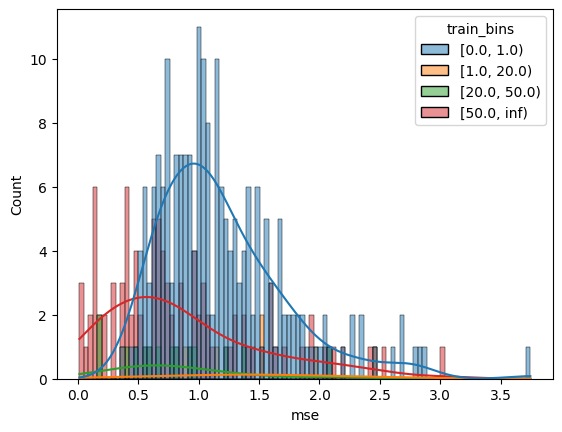

In [135]:
pd.concat([
    df_train['user id'].value_counts().rename('train count'),
    df_test['user id'].value_counts().rename('test count'), s_mse
], axis=1).pipe(lambda x: x.loc[x['test count'].notna()]).fillna(0)\
.assign(
    train_bins = lambda x: pd.cut(x['train count'], bins=[0, 1, 20, 50, np.inf], right=False)
).pipe(lambda x: sns.histplot(data=x, x='mse', hue='train_bins', bins=100, kde=True))
plt.show()

## 2. 지속적인 재학습 필요

사용자, 아이템이 추가될 때마다, 모델을 재구성해줘야 하고

새로운 데이터로 재학습을 시켜줘야합니다.